<a href="https://colab.research.google.com/github/AnIsAsPe/Named-Entity-Recognition-NER-con-LSTM-Bidireccionales/blob/main/Notebooks/Reconocimiento_de_Entidades_Nombradas_mediante_rnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

IMPORTANTE: Cambiar el entorno de ejecución para trabajar con GPU

<h1> RECONOCIMIENTIO DE ENTIDADES NOMBRADAS

(NER, Named-Entity-Recognition)

* El término de **entidades nombradas** fue acuñado por primera vez en 1995 para referirse al proceso de extraer unidades relevantes de información a partir de textos no estructurados..
* Estas unidades incluyen nombres propios de personas, organizaciones, lugares o expresiones numéricas como fechas o
cantidades, etc.
*  El REN se utiliza en sistemas de Pregunta-Respuesta (QA), la generación de resúmenes automáticos, la mejora de los sistemas de recuperación de la información, la traducción automática, la anonimización de textos, la generación de
grafos de conocimientos, etc.
* En los últimos años, el uso de las redes neuronales con el aprendizaje profundo y la integración de modelos del lenguaje con los WordEmbeddings ha supuesto un cambio en el
paradigma del PLN en general y en las tareas específicas como NER


# 1.Cargar bibliotecas

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import gensim  # para cargar modelo w2v
from sklearn.model_selection import train_test_split

from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

import tensorflow
from tensorflow.keras import Sequential, Model, Input
from tensorflow.keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Bidirectional
from tensorflow.keras.initializers import Constant
from tensorflow.keras.utils import plot_model


# 2.Leer Datos

In [3]:
csv_file ="https://raw.githubusercontent.com/AnIsAsPe/Named-Entity-Recognition-NER-con-LSTM-Bidireccionales/main/Datos/ner_datasetreference.csv"
data = pd.read_csv(csv_file, encoding= 'unicode_escape', usecols =[0,1,3])
data = data.fillna( method='ffill', axis=0)  # copia en los NaN la última observación válida, hasta encontrar la siguiente.
data.head()

,Sentence #,Word,Tag
0,Sentence: 1,Thousands,O
1,Sentence: 1,of,O
2,Sentence: 1,demonstrators,O
3,Sentence: 1,have,O
4,Sentence: 1,marched,O


In [4]:
data.loc[:50,]

,Sentence #,Word,Tag
0,Sentence: 1,Thousands,O
1,Sentence: 1,of,O
2,Sentence: 1,demonstrators,O
3,Sentence: 1,have,O
4,Sentence: 1,marched,O
5,Sentence: 1,through,O
6,Sentence: 1,London,B-geo
7,Sentence: 1,to,O
8,Sentence: 1,protest,O
9,Sentence: 1,the,O


In [5]:
data.nunique()  # Valores únicos en cada columna

Sentence #    47959
Word          35178
Tag              17
dtype: int64

In [6]:
data.Tag.value_counts()

O        887908
B-geo     37644
B-tim     20333
B-org     20143
I-per     17251
B-per     16990
I-org     16784
B-gpe     15870
I-geo      7414
I-tim      6528
B-art       402
B-eve       308
I-art       297
I-eve       253
B-nat       201
I-gpe       198
I-nat        51
Name: Tag, dtype: int64

* geo - Geographical Entity
* gpe - Geopolitical Entity
* per - Person
* org - Organization
* tim - Time indicator
* art - Artifact
* eve - Event
* nat - NaturalPhenomenon

[Inside-Outside-Beginning (tagging)](https://en.wikipedia.org/wiki/Inside%E2%80%93outside%E2%80%93beginning_(tagging))

In [7]:
data[data['Sentence #']=="Sentence: 66"]

,Sentence #,Word,Tag
1491,Sentence: 66,Energy,O
1492,Sentence: 66,",",O
1493,Sentence: 66,security,O
1494,Sentence: 66,",",O
1495,Sentence: 66,climate,O
1496,Sentence: 66,change,O
1497,Sentence: 66,",",O
1498,Sentence: 66,the,O
1499,Sentence: 66,World,B-org
1500,Sentence: 66,Trade,I-org


In [8]:
# promedio de palabras por sentencia
data.shape[0]/data['Sentence #'].nunique()

21.863987989741236

## 2.1.Pasar de tokens por renglón a la secuencia completa de la oración por renglón.

In [9]:
data['Sentence #'] = data['Sentence #'].str.replace('Sentence: ','').astype(int)
sentences = data.groupby(['Sentence #'],
                         as_index=False ).agg(lambda x: ' '.join(x))
sentences.columns=['ID', 'Sentence', 'Tags']

sentences.head(5)

,ID,Sentence,Tags
0,1,Thousands of demonstrators have marched throug...,O O O O O O B-geo O O O O O B-geo O O O O O B-...
1,2,Families of soldiers killed in the conflict jo...,O O O O O O O O O O O O O O O O O O B-per O O ...
2,3,They marched from the Houses of Parliament to ...,O O O O O O O O O O O B-geo I-geo O
3,4,"Police put the number of marchers at 10,000 wh...",O O O O O O O O O O O O O O O
4,5,The protest comes on the eve of the annual con...,O O O O O O O O O O O B-geo O O B-org I-org O ...


In [11]:
def vocabulario(pandas_series):
  lista_x_sentencia = pandas_series.str.split(" ")
  vocabulario = set()
  lista_x_sentencia.apply(vocabulario.update)

  return list(vocabulario)

In [12]:
vocabulario_palabras = vocabulario(sentences['Sentence'])
vocabulario_tags = vocabulario(sentences['Tags'])

In [13]:
len(vocabulario_palabras) == len(list(data.Word.unique()) )

True

# 3.Identificar cada token y cada etiqueta con un valor numérico

In [14]:
def get_dict_map(token_or_tag):
    if token_or_tag == 'token':
        # agregamos 'PAD_token' al vocabulario de tokens, para ser usado más
        # adelante a fin de que todas las oraciones tengan la misma cantidad de
        # tokens
        vocab = ['PAD_token'] + vocabulario(sentences['Sentence'])
    elif token_or_tag == 'tag':
        vocab = vocabulario(sentences['Tags'])

    idx2tok = {idx:tok for  idx, tok in enumerate(vocab)}
    tok2idx = {tok:idx for  idx, tok in enumerate(vocab)}
    return tok2idx, idx2tok


token2idx, idx2token = get_dict_map('token')
tag2idx, idx2tag = get_dict_map('tag')

In [18]:
tag2idx

{'B-per': 0,
 'I-tim': 1,
 'B-gpe': 2,
 'I-org': 3,
 'O': 4,
 'B-org': 5,
 'I-nat': 6,
 'I-geo': 7,
 'B-nat': 8,
 'I-per': 9,
 'B-eve': 10,
 'B-tim': 11,
 'I-art': 12,
 'I-gpe': 13,
 'I-eve': 14,
 'B-geo': 15,
 'B-art': 16}

In [19]:
n_tags = len(tag2idx)
n_tags

17

In [27]:
sentences['Sentence_idx'] = sentences['Sentence'].apply(lambda x: list(map(token2idx.get, x.split())))
sentences['Tags_idx'] = sentences['Tags'].apply(lambda x: list(map(tag2idx.get, x.split())))
sentences

,ID,Sentence,Tags,Sentence_idx,Tags_idx
0,1,Thousands of demonstrators have marched throug...,O O O O O O B-geo O O O O O B-geo O O O O O B-...,"[17380, 12895, 9546, 33147, 25781, 19807, 1821...","[4, 4, 4, 4, 4, 4, 15, 4, 4, 4, 4, 4, 15, 4, 4..."
1,2,Families of soldiers killed in the conflict jo...,O O O O O O O O O O O O O O O O O O B-per O O ...,"[24390, 12895, 32054, 29096, 9115, 29372, 1998...","[4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, ..."
2,3,They marched from the Houses of Parliament to ...,O O O O O O O O O O O B-geo I-geo O,"[21315, 25781, 18116, 29372, 22774, 12895, 877...","[4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 15, 7, 4]"
3,4,"Police put the number of marchers at 10,000 wh...",O O O O O O O O O O O O O O O,"[4835, 2109, 29372, 29853, 12895, 14517, 16412...","[4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4]"
4,5,The protest comes on the eve of the annual con...,O O O O O O O O O O O B-geo O O B-org I-org O ...,"[30082, 20857, 16112, 27832, 29372, 2029, 1289...","[4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 15, 4, 4, 5,..."
...,...,...,...,...,...
47954,47955,Indian border security forces are accusing the...,B-gpe O O O O O O B-gpe O O O O O O O O O B-ge...,"[33394, 6886, 16682, 15719, 5776, 439, 20590, ...","[2, 4, 4, 4, 4, 4, 4, 2, 4, 4, 4, 4, 4, 4, 4, ..."
47955,47956,Indian officials said no one was injured in Sa...,B-gpe O O O O O O O B-tim O O O O O O O O O O ...,"[33394, 19486, 1276, 19400, 30695, 19871, 1215...","[2, 4, 4, 4, 4, 4, 4, 4, 11, 4, 4, 4, 4, 4, 4,..."
47956,47957,Two more landed in fields belonging to a nearb...,O O O O O O O O O O O,"[20689, 23837, 34528, 9115, 25618, 18251, 1723...","[4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4]"
47957,47958,They say not all of the rockets exploded upon ...,O O O O O O O O O O O,"[21315, 18713, 25029, 21491, 12895, 29372, 120...","[4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4]"


# 4.Preparar las secuencias que ingresarán a nuestra red neuronal.

Padding: Las capas de LSTM necesitan que cada secuencias (oración) tenga la misma longitud, se puede usar cualquier longitud, pero entre más grande sea mayor será el costo del entrenamiento.

Las oraciones  que sean más cortas se "rellenaran" con el token que agregamos anterioremente ('PAD_token')


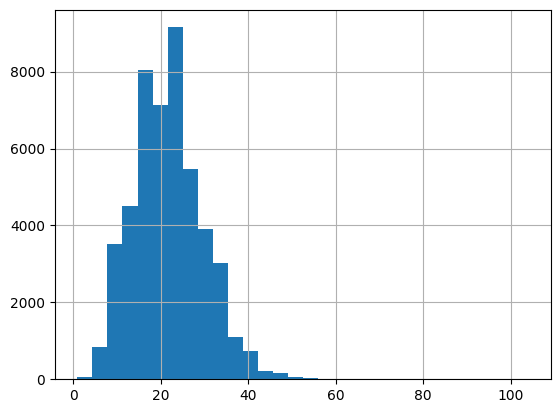

La oración más larga tiene 104 tokens


In [21]:

palabras_sentencia = sentences['Sentence'].apply(lambda x: len(str(x).split()))

palabras_sentencia.hist(bins=30)
plt.show()
print('La oración más larga tiene {} tokens'.format(palabras_sentencia.max()))

In [23]:
max_len = int(palabras_sentencia.quantile(0.9975))
max_len

50

In [26]:
sentences.columns

Index(['ID', 'Sentence', 'Tags'], dtype='object')

In [28]:
pad_tokens = pad_sequences(sentences['Sentence_idx'], maxlen=max_len,
                           dtype='int32', padding='post',
                           value = token2idx['PAD_token'])
pad_tags = pad_sequences(sentences['Tags_idx'], maxlen=max_len,
                         dtype='int32', padding='post',
                         value= tag2idx["O"])

# Hacemos un One Hot Encoding para la secuencia de etiquetas
pad_tags = [to_categorical(i, num_classes=len(tag2idx)) for i in pad_tags]

## Ejemplo

In [29]:
ej = 9
longitud = len(sentences.loc[ej, 'Sentence'].split())

print(
f'''Longitud: {longitud}

{sentences.loc[ej, "Sentence"]}\n{sentences.loc[ej, "Sentence_idx"]}

{sentences.loc[ej, "Tags"]}\n{sentences.loc[ej, "Tags_idx"]}
'''
)

Longitud: 25

Iranian officials say they expect to get access to sealed sensitive parts of the plant Wednesday , after an IAEA surveillance system begins functioning .
[8315, 19486, 18713, 28130, 9744, 17237, 32760, 30782, 17237, 10171, 31874, 7227, 12895, 29372, 22245, 32997, 27586, 14625, 19318, 5126, 24161, 32241, 17859, 15735, 20913]

B-gpe O O O O O O O O O O O O O O B-tim O O O B-org O O O O O
[2, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 11, 4, 4, 4, 5, 4, 4, 4, 4, 4]



In [35]:
idx2tag

{0: 'B-per',
 1: 'I-tim',
 2: 'B-gpe',
 3: 'I-org',
 4: 'O',
 5: 'B-org',
 6: 'I-nat',
 7: 'I-geo',
 8: 'B-nat',
 9: 'I-per',
 10: 'B-eve',
 11: 'B-tim',
 12: 'I-art',
 13: 'I-gpe',
 14: 'I-eve',
 15: 'B-geo',
 16: 'B-art'}

In [30]:
pad_tokens[ej]

array([ 8315, 19486, 18713, 28130,  9744, 17237, 32760, 30782, 17237,
       10171, 31874,  7227, 12895, 29372, 22245, 32997, 27586, 14625,
       19318,  5126, 24161, 32241, 17859, 15735, 20913,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0], dtype=int32)

In [31]:
for token, tag in zip(pad_tokens[ej], pad_tags[ej]):
    print('%s\t%s' % (token, tag))

8315	[0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
19486	[0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
18713	[0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
28130	[0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
9744	[0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
17237	[0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
32760	[0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
30782	[0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
17237	[0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
10171	[0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
31874	[0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
7227	[0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
12895	[0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
29372	[0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
22245	[0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
32997	[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
27586	[0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


# 5.Obtener la matriz de encajes para todas las palabras del vocabulario

<h2> Modelo Preentrenado Word2Vec<h3>

Utilizaremos los vectores word2vec preentrenados con el corpus GoogleNews.
Cuenta con 3 millones vectores de 300 dimensiones correspondientes a 3 millones de palabras y frases en inglés.
Crea un acceso directo en tu drive del modelo preentrenado que está disponible en este [enlace](https://drive.google.com/file/d/0B7XkCwpI5KDYNlNUTTlSS21pQmM/edit?resourcekey=0-wjGZdNAUop6WykTtMip30g)


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Si es la primera vez que corres el notebook, descomenta las siguientes lineas para cargar el modelo preentrenado completo.

In [ ]:
# %%time
# # asegurate de poner la ruta correcta en donde se ubica el archivo en tu drive
# file =  '/content/drive/MyDrive/Embeddings/GoogleNews-vectors-negative300.bin.gz'
# w2v = gensim.models.KeyedVectors.load_word2vec_format(file,  binary=True)

In [ ]:
# print('Palabras en el modelo w2v: {:,} '.format(len(w2v.vocab)))
# print('Dimensiones por embedding: ', w2v.vector_size)

<h3> Reducción del diccionario de embeddings para tener solo los tokens presentes en nuestro corpus.

Guardar en pikle
Así no tendremos que volver a cargar todo el modelo word embedding

In [ ]:
# dic_tokens_word2vec  = {}
# palabras_sin_embedding =[]
# for token in data.Word.unique():
#   try:
#     dic_tokens_word2vec[token] = w2v[token]
#   except:
#     palabras_sin_embedding.append(token)

In [ ]:
# import pickle
# path = '/content/drive/MyDrive/Pikles'
# pickle.dump(dic_tokens_word2vec, open (path + "dic_tokens_ner_w2v.pkl", 'wb'))

In [36]:
import pickle
path = '/content/drive/MyDrive/Pikles'
dic_tokens_word2vec = pickle.load(open(path + "dic_tokens_ner_w2v.pkl", 'rb'))
palabras_sin_embedding = [tok for tok in data.Word.unique() if tok not in dic_tokens_word2vec.keys()]


In [37]:
len(vocabulario_palabras)

35178

In [ ]:
len(palabras_sin_embedding)

6276

In [38]:
# Tokens más frecuentes sin embbedding en nuestros datos.
data[data.Word.isin(palabras_sin_embedding)]['Word'].value_counts(normalize=True).cumsum().head(35)

.           0.222285
,           0.374725
of          0.497380
to          0.605416
a           0.700736
and         0.793521
's          0.844357
"           0.861512
-           0.866967
)           0.870062
(           0.873152
10          0.875163
'           0.877094
al-Qaida    0.878947
2003        0.880543
20          0.882065
30          0.883405
15          0.884732
11          0.885970
2008        0.887124
2004        0.888246
2001        0.889330
12          0.890400
U.S.-led    0.891438
2010        0.892453
H5N1        0.893454
50          0.894440
;           0.895408
2006        0.896376
2009        0.897344
25          0.898294
100         0.899211
2002        0.900076
2007        0.900933
40          0.901780
Name: Word, dtype: float64

In [39]:
# número de palabras del vocabulario encontradas en el modelo word2vec
len(data[data.Word.isin(dic_tokens_word2vec)]['Word'].unique())

28902

In [40]:
len(token2idx)

35179

In [42]:
num_tokens = len(token2idx)
embedding_dim = 300
embedding_matrix = np.zeros((num_tokens, embedding_dim))
for token, i in token2idx.items():
    if token in dic_tokens_word2vec.keys():
       embedding_matrix[i] = dic_tokens_word2vec[token]


In [43]:
pd.DataFrame(embedding_matrix)

,0,1,2,3,4,5,6,7,8,9,...,290,291,292,293,294,295,296,297,298,299
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,-0.051758,0.025635,-0.197266,0.186523,-0.152344,-0.092773,0.419922,-0.142578,0.345703,-0.004456,...,0.179688,-0.116699,-0.107422,-0.376953,-0.045654,-0.183594,0.072266,-0.079102,0.017700,-0.127930
2,0.164062,0.182617,-0.128906,-0.051514,0.034424,-0.227539,-0.240234,-0.109375,0.539062,-0.132812,...,0.171875,0.022583,-0.244141,0.035889,0.247070,0.066406,0.071777,-0.396484,-0.104004,-0.101562
3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,-0.028931,0.107910,-0.107422,0.186523,-0.002335,-0.019775,0.100098,-0.120117,-0.178711,0.205078,...,0.042236,0.108398,-0.043457,-0.092773,0.066406,-0.101562,0.386719,-0.060303,0.132812,-0.010864
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35174,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
35175,-0.318359,0.139648,-0.032959,0.163086,-0.136719,0.037109,-0.028809,-0.041260,-0.230469,0.314453,...,-0.083008,-0.228516,-0.251953,0.020752,0.386719,0.191406,0.069824,-0.002274,0.466797,0.281250
35176,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
35177,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


# 6.Dividir en conjunto de entrenamiento y prueba

In [51]:
train_tokens, test_tokens, train_tags, test_tags = train_test_split(
pad_tokens, pad_tags, test_size=0.1, train_size=0.9, random_state=2020)

print(
f'''train_tokens: {len(train_tokens)}
train_tags: {len(train_tags)}

test_tokens: {len(test_tokens)}
test_tags: {len(test_tags)}'''
)

train_tokens: 43163
train_tags: 43163

test_tokens: 4796
test_tags: 4796


# 7.Construcción de la Arquitectura del Modelo


- **Embedding layer** : Será la primera capa de nuestro modelo en el que ingresaremos las secuencias todas de tamaño 50. Esta capa no la entrenaremos (training = False), sino que en su lugar la alimentaremos con la matriz de embedings que preparamos en el paso 5. La salida de esa capa será un tensor de tres dimensiones para alimentar a la capa LSTM [Bath size, timesteps, features] que en nuestro caso se traducirá en [None, 50, 300]

- **Bidirectional LSTM** : Tomará la salida de la capa de embedings y concatenará las salidas de las dos direcciones del LSTM, cada salida tendra las unidades que se declaren en la capa LSTM (128) y al concatenarse, la salida será del doble de unidades (None, 50, 256)

- **TimeDistributed  Layer** : La arquitectura de nuestra RNN es de tipo muchas a muchas, en donde para cada token (timestep) de la secuencia de entrada, esperamos la probabilidad de pertenencia a cada  una de las clases. Para ello se usa esta capa activada por la función 'Softmax'. La salida de esta capa será un tensor de (None, 50, 17)

In [46]:
from numpy.random import seed
seed(1)
tensorflow.random.set_seed(2)

In [47]:
input = Input(shape = (max_len,))

# Capa de Embedding
embedding = Embedding(input_dim = num_tokens,
                      output_dim = 300,
                      embeddings_initializer = Constant(embedding_matrix),
                      trainable=False)(input)
# Capa 1 LSTM Bidireccional
LSTM_Bi = Bidirectional(LSTM(units=128,
                             return_sequences=True, # Todos los estados h para cada timestep
                             recurrent_dropout=0.2, dropout=0.2  # Para evitar sobreajuste
                             ))(embedding)
# Capa de Salida
out = TimeDistributed(
    Dense(n_tags,               # dimensiones de salida (17 clases de los Tags)
          activation="softmax"  # para obtener una probabilidad para cada clase
                                # función de activación
                                # https://www.tensorflow.org/api_docs/python/tf/keras/activations
          ))(LSTM_Bi)

NER_model = Model(input, out)  # unión del modelo
NER_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 50)]              0         
                                                                 
 embedding (Embedding)       (None, 50, 300)           10553700  
                                                                 
 bidirectional (Bidirection  (None, 50, 256)           439296    
 al)                                                             
                                                                 
 time_distributed (TimeDist  (None, 50, 17)            4369      
 ributed)                                                        
                                                                 
Total params: 10997365 (41.95 MB)
Trainable params: 443665 (1.69 MB)
Non-trainable params: 10553700 (40.26 MB)
_________________________________________________________________


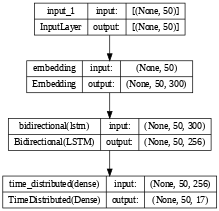

In [48]:
plot_model(
    NER_model,
    show_shapes=True,
    show_dtype=False,
    show_layer_names=True,
    rankdir="TD",
    dpi=50,
)

# 8.Entrenamiento del modelo

In [49]:
# Compile model
NER_model.compile(optimizer='adam',         # el optimizador sirve para encontrar los pesos que minimizan la función de pérdida
                                            # adam: stochastic gradient descent adaptativo
                                            # https://www.tensorflow.org/api_docs/python/tf/keras/optimizers
                  loss="categorical_crossentropy", # función que evalua que tan bien el algoritmo modela el conjunto de datos
                                                   # https://www.tensorflow.org/api_docs/python/tf/keras/losses
                  metrics=['accuracy'])

In [53]:
history = NER_model.fit(train_tokens, np.array(train_tags),
                        validation_split=0.2,
                        batch_size=200,
                        epochs=5,   # número de iteraciones sobre los datos
                        verbose=1)

Epoch 1/5
173/173 [==============================] - 217s 1s/step - loss: 0.2298 - accuracy: 0.9511 - val_loss: 0.1134 - val_accuracy: 0.9721
Epoch 2/5
173/173 [==============================] - 214s 1s/step - loss: 0.1017 - accuracy: 0.9736 - val_loss: 0.0870 - val_accuracy: 0.9765
Epoch 3/5
173/173 [==============================] - 215s 1s/step - loss: 0.0846 - accuracy: 0.9770 - val_loss: 0.0761 - val_accuracy: 0.9789
Epoch 4/5
173/173 [==============================] - 216s 1s/step - loss: 0.0757 - accuracy: 0.9788 - val_loss: 0.0700 - val_accuracy: 0.9802
Epoch 5/5
173/173 [==============================] - 216s 1s/step - loss: 0.0704 - accuracy: 0.9798 - val_loss: 0.0662 - val_accuracy: 0.9808


In [54]:
# Guardar todo el modelo  https://www.tensorflow.org/tutorials/keras/save_and_load
NER_model.save_weights('/content/drive/MyDrive/Modelos/Weights_NER_oct23')

In [55]:
# Leer el modelo guardado
NER_model.load_weights('/content/drive/MyDrive/Modelos/Weights_NER_oct23')

# 9.Predicción y Evaluación

In [56]:
test_pred = NER_model.predict(np.array(test_tokens), verbose=1)

150/150 [==============================] - 11s 66ms/step


In [57]:
test_tokens.shape

(4796, 50)

In [58]:
test_pred.shape

(4796, 50, 17)

In [59]:
test_pred[0].shape

(50, 17)

In [60]:
pd.DataFrame(test_pred[0])

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
0,0.000069,1.461390e-04,1.907805e-05,4.372736e-05,0.998757,0.000188,1.122483e-05,2.326949e-05,3.149378e-05,3.225763e-05,2.184537e-05,0.000349,7.667712e-05,1.377737e-05,3.491759e-05,0.000149,3.335997e-05
1,0.000276,1.033489e-03,1.179109e-04,3.561531e-05,0.992922,0.000253,2.083838e-05,2.356063e-05,7.452958e-05,3.659674e-05,3.614303e-05,0.004570,6.158317e-05,3.445718e-05,5.164359e-05,0.000377,7.532315e-05
2,0.000244,4.724749e-04,1.276999e-05,1.887350e-05,0.996554,0.000441,1.012100e-05,4.656250e-06,3.410953e-05,1.390707e-05,1.451006e-05,0.001648,2.814617e-05,7.725522e-06,2.412715e-05,0.000393,7.847611e-05
3,0.000649,1.472648e-03,1.209496e-04,6.529035e-05,0.986691,0.002057,3.364772e-05,5.192836e-05,8.872859e-05,7.311168e-05,4.433974e-05,0.006672,8.697501e-05,5.447909e-05,7.310374e-05,0.001526,2.403388e-04
4,0.000130,4.826415e-04,5.129054e-05,2.726913e-05,0.996737,0.000556,1.492322e-05,2.323133e-05,3.530315e-05,2.095370e-05,1.537046e-05,0.001303,3.993273e-05,1.738422e-05,3.125545e-05,0.000432,8.343216e-05
5,0.000023,6.453707e-05,6.165449e-06,1.561113e-06,0.999664,0.000057,1.667125e-06,9.533978e-07,6.692621e-06,1.917519e-06,2.121272e-06,0.000041,3.815635e-06,1.266870e-06,4.398871e-06,0.000109,1.045548e-05
6,0.000001,1.804324e-05,2.970150e-07,4.947741e-07,0.999848,0.000003,2.011995e-07,1.301047e-07,9.077777e-07,4.003579e-07,3.460965e-07,0.000121,4.999275e-07,1.324963e-07,5.560969e-07,0.000004,9.974001e-07
7,0.000038,4.292970e-03,3.646432e-06,1.640819e-06,0.012680,0.000074,1.259003e-06,1.826665e-06,5.854577e-06,3.848382e-06,8.815102e-06,0.982650,2.305050e-06,2.109226e-06,6.043452e-06,0.000216,1.116815e-05
8,0.000003,6.059244e-05,5.783191e-06,2.611580e-06,0.999836,0.000021,6.828566e-07,1.395723e-06,2.349626e-06,1.595134e-06,1.145446e-06,0.000018,2.466596e-06,6.931108e-07,2.569258e-06,0.000037,3.270081e-06
9,0.000013,2.584169e-05,2.939095e-06,9.275548e-07,0.999823,0.000021,3.767635e-07,6.129162e-07,1.532675e-06,4.480317e-07,5.045694e-07,0.000071,1.047269e-06,6.664903e-07,1.277427e-06,0.000033,2.969019e-06


In [61]:
test_tokens[0:2]

array([[18719,  8660,  4651, 27586,  8336, 21614, 24704, 26829, 29096,
        30695, 17473,  9115, 29372, 29970, 11229, 11007, 12895,  4489,
        20913,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0],
       [ 8106,  1798, 12445, 27586, 14206, 17624, 26005,  2135, 27586,
          197, 29372, 21005, 29161,  3414, 17237, 18042,  4207, 15594,
        33400, 29372,  9864, 27586,  6324, 10247, 27637, 29372,   346,
        30612, 16571, 19871, 25029, 29372, 13618,  4519, 20913,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0]], dtype=int32)

In [62]:
 test_tokens[0,1] #  M[i, j]

8660

In [63]:
def secIdx2secTok(M):
  n = M.shape[0]
  d = M.shape[1]
  oraciones = []
  for i in range(n):
      tokens = []
      for j in range(d):
          idx = M[i, j]
          tokens.append(idx2token[idx])
      oraciones.append(tokens)
  return oraciones

test_toks = secIdx2secTok(test_tokens)


In [64]:

def secIdx2secTag(pred):
    out = []
    for pred_i in pred:
        out_i = []
        for p in pred_i:
            p_i = np.argmax(p)
            out_i.append(idx2tag[p_i])
        out.append(out_i)
    return out



pred_labels = secIdx2secTag(test_pred)
test_labels = secIdx2secTag(test_tags)

In [65]:
dfs = {}
for idx in range(len(test_labels)):
  dfs[idx] = pd.DataFrame({'ID': idx, 'Word': test_toks[idx],
                           'Pred':pred_labels[idx], 'Tag':test_labels[idx]})

resultados = pd.concat(dfs, ignore_index = True).set_index('ID')
resultados = resultados[resultados['Word']!='PAD_token']
resultados['acierto'] = np.where(resultados['Pred']==resultados['Tag'],1,0)
resultados['acierto'].mean()

0.9561890131148474

In [66]:
resultados.loc[54]  # 4 , 8 , 87

,Word,Pred,Tag,acierto
ID,,,,
54,A,O,O,1
54,Royal,B-org,B-org,1
54,Nepalese,B-gpe,B-gpe,1
54,Army,I-org,B-org,0
54,spokesman,O,O,1
54,",",O,O,1
54,Brigadier-General,O,O,1
54,Deepak,B-per,B-per,1
54,Gurung,I-per,I-per,1


# Referencias

1. Karakaya M. LSTM: Understanding Output Types [Internet]. Deep Learning Tutorials with Keras. 2021 [citado 14 de julio de 2022]. Disponible en: https://www.muratkarakaya.net/2022/11/lstm-understanding-output-types.html



2. Nair S. Named-Entity Recognition (NER) using Keras Bidirectional LSTM [Internet]. Medium. 2020 [citado 14 de julio de 2022]. Disponible en: https://towardsdatascience.com/named-entity-recognition-ner-using-keras-bidirectional-lstm-28cd3f301f54

3. Samy D. Reconocimiento y clasificación de entidades nombradas en textos legales en español. Procesamiento del Lenguaje Natural. 2021;103-14.

4. Sarkar S. Named Entity Recognition using Deep Learning(ELMo Embedding+ Bi-LSTM) [Internet]. Analytics Vidhya. 2021 [citado 14 de julio de 2022]. Disponible en: https://medium.com/analytics-vidhya/named-entity-recognition-using-deep-learning-elmo-embedding-bi-lstm-48295bc66cab







